<a href="https://colab.research.google.com/github/kangnurrohman/belajar-recurrent-neural-network/blob/main/materi/Part%204%20-%20LSTM%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install jcopdl luwiji

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 4.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import Data

In [6]:
df = pd.read_csv("/content/data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


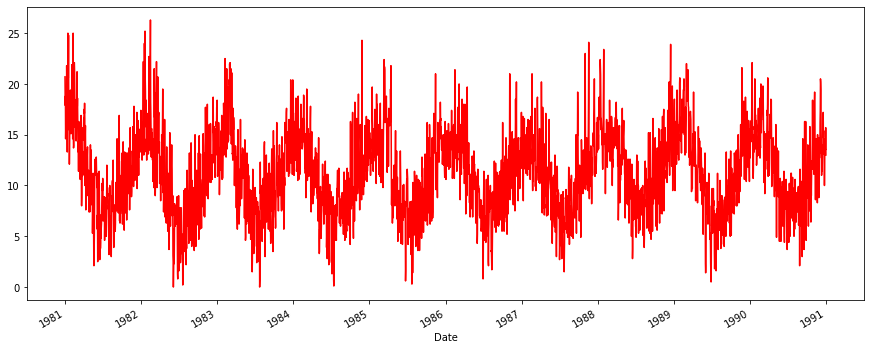

In [7]:
df.Temp.plot(figsize=(15, 6), color='red')

## Dataset Spliting

In [8]:
ts_train, ts_test = train_test_split(df, shuffle=False)
ts_train.shape, ts_test.shape

((2737, 1), (913, 1))

## Dataset & Dataloader

In [9]:
from jcopdl.utils import TimeSeriesDataset
from torch.utils.data import DataLoader

In [10]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=2)

(N, S, F): (195, 14, 1)
Note: last 6 data excluded

(N, S, F): (65, 14, 1)
Note: last 2 data excluded



## Arsitektur & Config

In [15]:
class LSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):
    x, hidden = self.rnn(x, hidden)
    x = self.fc(x)
    return x, hidden

In [16]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size":64,
    "num_layers": 2,
    "dropout":0
})

## Training Preparation -> MCOC

In [17]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='/content/data/model/lstm')

## Training

In [18]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output, hidden = model(feature, None)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  cost = cost / len(dataset)
  return cost

Test: 100%|██████████| 3/3 [00:00<00:00, 38.20it/s]



Epoch     1
Train_cost  = 133.6253 | Test_cost  = 131.4262 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.66it/s]



Epoch     2
Train_cost  = 122.1308 | Test_cost  = 114.5615 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.46it/s]



Epoch     3
Train_cost  = 103.5677 | Test_cost  = 94.3563 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.99it/s]



Epoch     4
Train_cost  = 84.6403 | Test_cost  = 76.9444 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.69it/s]



Epoch     5
Train_cost  = 69.0669 | Test_cost  = 63.5332 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.18it/s]



Epoch     6
Train_cost  = 57.4506 | Test_cost  = 53.7276 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.48it/s]



Epoch     7
Train_cost  = 48.9770 | Test_cost  = 46.4357 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.71it/s]



Epoch     8
Train_cost  = 42.6069 | Test_cost  = 40.7261 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.73it/s]



Epoch     9
Train_cost  = 37.5596 | Test_cost  = 36.0723 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.50it/s]



Epoch    10
Train_cost  = 33.4733 | Test_cost  = 32.3138 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.80it/s]



Epoch    11
Train_cost  = 30.2033 | Test_cost  = 29.2852 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.69it/s]



Epoch    12
Train_cost  = 27.5830 | Test_cost  = 26.8355 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.91it/s]



Epoch    13
Train_cost  = 25.4809 | Test_cost  = 24.8564 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.92it/s]



Epoch    14
Train_cost  = 23.7993 | Test_cost  = 23.2617 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.74it/s]



Epoch    15
Train_cost  = 22.4590 | Test_cost  = 21.9805 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.25it/s]



Epoch    16
Train_cost  = 21.3947 | Test_cost  = 20.9540 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.03it/s]



Epoch    17
Train_cost  = 20.5525 | Test_cost  = 20.1335 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.46it/s]



Epoch    18
Train_cost  = 19.8880 | Test_cost  = 19.4791 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.60it/s]



Epoch    19
Train_cost  = 19.3652 | Test_cost  = 18.9584 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.50it/s]



Epoch    20
Train_cost  = 18.9547 | Test_cost  = 18.5447 | 


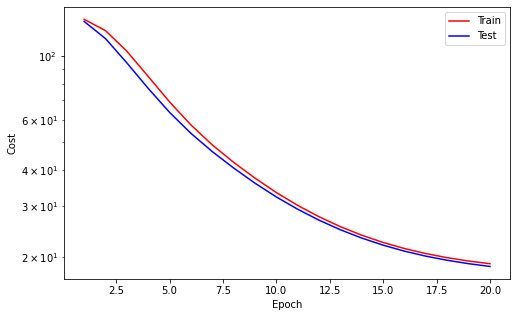

Test: 100%|██████████| 3/3 [00:00<00:00, 38.17it/s]



Epoch    21
Train_cost  = 18.6328 | Test_cost  = 18.2164 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.44it/s]



Epoch    22
Train_cost  = 18.3804 | Test_cost  = 17.9556 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.73it/s]



Epoch    23
Train_cost  = 18.1821 | Test_cost  = 17.7480 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.63it/s]



Epoch    24
Train_cost  = 18.0253 | Test_cost  = 17.5820 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.79it/s]



Epoch    25
Train_cost  = 17.9006 | Test_cost  = 17.4485 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.00it/s]



Epoch    26
Train_cost  = 17.8004 | Test_cost  = 17.3403 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 11.93it/s]



Epoch    27
Train_cost  = 17.7189 | Test_cost  = 17.2520 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.00it/s]



Epoch    28
Train_cost  = 17.6518 | Test_cost  = 17.1791 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.24it/s]



Epoch    29
Train_cost  = 17.5957 | Test_cost  = 17.1185 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.95it/s]



Epoch    30
Train_cost  = 17.5482 | Test_cost  = 17.0675 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.29it/s]



Epoch    31
Train_cost  = 17.5076 | Test_cost  = 17.0245 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.33it/s]



Epoch    32
Train_cost  = 17.4727 | Test_cost  = 16.9881 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.30it/s]



Epoch    33
Train_cost  = 17.4426 | Test_cost  = 16.9569 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.31it/s]



Epoch    34
Train_cost  = 17.4163 | Test_cost  = 16.9299 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.53it/s]



Epoch    35
Train_cost  = 17.3930 | Test_cost  = 16.9062 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.47it/s]



Epoch    36
Train_cost  = 17.3721 | Test_cost  = 16.8853 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.02it/s]



Epoch    37
Train_cost  = 17.3534 | Test_cost  = 16.8668 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.68it/s]



Epoch    38
Train_cost  = 17.3365 | Test_cost  = 16.8503 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.25it/s]



Epoch    39
Train_cost  = 17.3211 | Test_cost  = 16.8354 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.41it/s]



Epoch    40
Train_cost  = 17.3071 | Test_cost  = 16.8219 | 


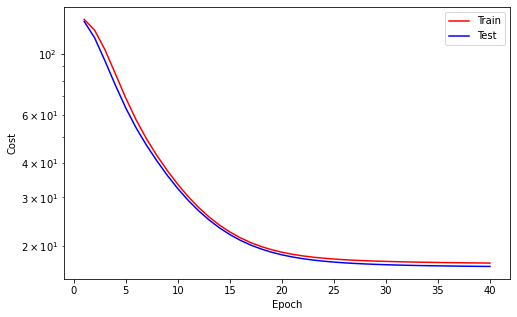

Test: 100%|██████████| 3/3 [00:00<00:00, 38.28it/s]



Epoch    41
Train_cost  = 17.2941 | Test_cost  = 16.8096 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.80it/s]



Epoch    42
Train_cost  = 17.2822 | Test_cost  = 16.7984 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.41it/s]



Epoch    43
Train_cost  = 17.2711 | Test_cost  = 16.7880 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.36it/s]



Epoch    44
Train_cost  = 17.2608 | Test_cost  = 16.7783 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.16it/s]



Epoch    45
Train_cost  = 17.2512 | Test_cost  = 16.7693 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.33it/s]



Epoch    46
Train_cost  = 17.2421 | Test_cost  = 16.7610 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.24it/s]



Epoch    47
Train_cost  = 17.2336 | Test_cost  = 16.7531 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.56it/s]



Epoch    48
Train_cost  = 17.2256 | Test_cost  = 16.7457 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.81it/s]



Epoch    49
Train_cost  = 17.2180 | Test_cost  = 16.7387 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.82it/s]



Epoch    50
Train_cost  = 17.2108 | Test_cost  = 16.7321 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.27it/s]



Epoch    51
Train_cost  = 17.2039 | Test_cost  = 16.7258 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.84it/s]



Epoch    52
Train_cost  = 17.1973 | Test_cost  = 16.7198 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 23.60it/s]



Epoch    53
Train_cost  = 17.1910 | Test_cost  = 16.7140 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.13it/s]



Epoch    54
Train_cost  = 17.1848 | Test_cost  = 16.7084 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.21it/s]



Epoch    55
Train_cost  = 17.1787 | Test_cost  = 16.7029 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.47it/s]



Epoch    56
Train_cost  = 17.1726 | Test_cost  = 16.6974 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.27it/s]



Epoch    57
Train_cost  = 17.1666 | Test_cost  = 16.6921 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.73it/s]



Epoch    58
Train_cost  = 17.1608 | Test_cost  = 16.6872 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.94it/s]



Epoch    59
Train_cost  = 17.1555 | Test_cost  = 16.6825 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.05it/s]



Epoch    60
Train_cost  = 17.1502 | Test_cost  = 16.6779 | 


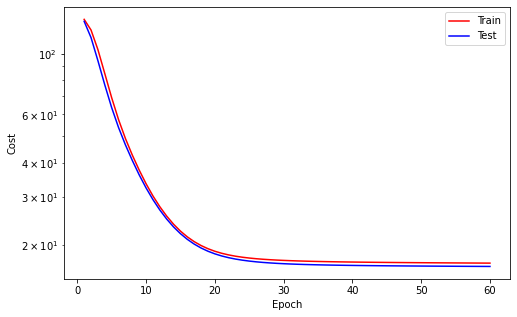

Test: 100%|██████████| 3/3 [00:00<00:00, 31.86it/s]



Epoch    61
Train_cost  = 17.1449 | Test_cost  = 16.6732 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.06it/s]



Epoch    62
Train_cost  = 17.1396 | Test_cost  = 16.6686 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.08it/s]



Epoch    63
Train_cost  = 17.1341 | Test_cost  = 16.6635 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.43it/s]



Epoch    64
Train_cost  = 17.1281 | Test_cost  = 16.6581 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.20it/s]



Epoch    65
Train_cost  = 17.1217 | Test_cost  = 16.6528 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.65it/s]



Epoch    66
Train_cost  = 17.1141 | Test_cost  = 16.6447 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.22it/s]



Epoch    67
Train_cost  = 17.1010 | Test_cost  = 16.6338 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.78it/s]



Epoch    68
Train_cost  = 17.0910 | Test_cost  = 16.6276 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.33it/s]



Epoch    69
Train_cost  = 17.0786 | Test_cost  = 16.6131 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.20it/s]



Epoch    70
Train_cost  = 17.0574 | Test_cost  = 16.6080 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.08it/s]



Epoch    71
Train_cost  = 17.0460 | Test_cost  = 16.5901 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.38it/s]



Epoch    72
Train_cost  = 17.0231 | Test_cost  = 16.5604 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.36it/s]



Epoch    73
Train_cost  = 16.9899 | Test_cost  = 16.5221 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.70it/s]



Epoch    74
Train_cost  = 16.9338 | Test_cost  = 16.4646 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.71it/s]



Epoch    75
Train_cost  = 16.8410 | Test_cost  = 16.2958 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.20it/s]



Epoch    76
Train_cost  = 16.5043 | Test_cost  = 15.6872 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.51it/s]



Epoch    77
Train_cost  = 15.5164 | Test_cost  = 14.4690 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.09it/s]



Epoch    78
Train_cost  = 13.9415 | Test_cost  = 13.3597 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.36it/s]



Epoch    79
Train_cost  = 13.0040 | Test_cost  = 12.4790 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.00it/s]



Epoch    80
Train_cost  = 12.1791 | Test_cost  = 11.9006 | 


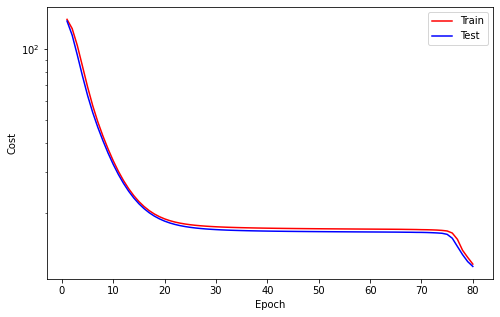

Test: 100%|██████████| 3/3 [00:00<00:00, 32.17it/s]



Epoch    81
Train_cost  = 11.5607 | Test_cost  = 10.9729 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.60it/s]



Epoch    82
Train_cost  = 10.8505 | Test_cost  = 10.5533 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.21it/s]



Epoch    83
Train_cost  = 10.2509 | Test_cost  = 9.9687 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.36it/s]



Epoch    84
Train_cost  = 9.8305 | Test_cost  = 9.5554 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.51it/s]



Epoch    85
Train_cost  = 9.4349 | Test_cost  = 9.2494 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.98it/s]



Epoch    86
Train_cost  = 9.1147 | Test_cost  = 8.8862 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.35it/s]



Epoch    87
Train_cost  = 8.8531 | Test_cost  = 8.6199 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.74it/s]



Epoch    88
Train_cost  = 8.6193 | Test_cost  = 8.4049 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.13it/s]



Epoch    89
Train_cost  = 8.4095 | Test_cost  = 8.2054 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.03it/s]



Epoch    90
Train_cost  = 8.2466 | Test_cost  = 8.0293 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.55it/s]



Epoch    91
Train_cost  = 8.0977 | Test_cost  = 7.8689 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.42it/s]



Epoch    92
Train_cost  = 7.9599 | Test_cost  = 7.7383 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.48it/s]



Epoch    93
Train_cost  = 7.8435 | Test_cost  = 7.6160 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.94it/s]



Epoch    94
Train_cost  = 7.7453 | Test_cost  = 7.4965 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.94it/s]



Epoch    95
Train_cost  = 7.6514 | Test_cost  = 7.3985 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 18.75it/s]



Epoch    96
Train_cost  = 7.5635 | Test_cost  = 7.3171 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.75it/s]



Epoch    97
Train_cost  = 7.4887 | Test_cost  = 7.2253 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.68it/s]



Epoch    98
Train_cost  = 7.4234 | Test_cost  = 7.1491 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.89it/s]



Epoch    99
Train_cost  = 7.3584 | Test_cost  = 7.0871 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.25it/s]



Epoch   100
Train_cost  = 7.2988 | Test_cost  = 7.0231 | 


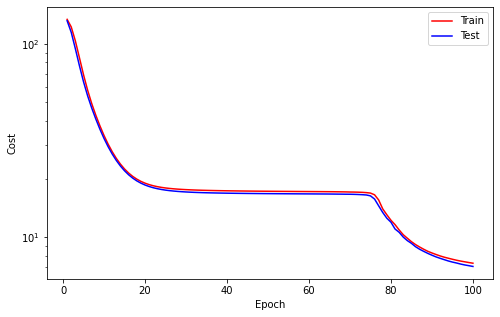

Test: 100%|██████████| 3/3 [00:00<00:00, 30.76it/s]



Epoch   101
Train_cost  = 7.2489 | Test_cost  = 6.9595 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.38it/s]



Epoch   102
Train_cost  = 7.2008 | Test_cost  = 6.9083 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.06it/s]



Epoch   103
Train_cost  = 7.1540 | Test_cost  = 6.8618 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.30it/s]



Epoch   104
Train_cost  = 7.1134 | Test_cost  = 6.8112 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 22.57it/s]



Epoch   105
Train_cost  = 7.0761 | Test_cost  = 6.7680 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.53it/s]



Epoch   106
Train_cost  = 7.0392 | Test_cost  = 6.7306 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.28it/s]



Epoch   107
Train_cost  = 7.0051 | Test_cost  = 6.6920 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.02it/s]



Epoch   108
Train_cost  = 6.9745 | Test_cost  = 6.6550 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.02it/s]



Epoch   109
Train_cost  = 6.9445 | Test_cost  = 6.6231 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.73it/s]



Epoch   110
Train_cost  = 6.9154 | Test_cost  = 6.5927 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.03it/s]



Epoch   111
Train_cost  = 6.8890 | Test_cost  = 6.5613 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.82it/s]



Epoch   112
Train_cost  = 6.8636 | Test_cost  = 6.5331 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.78it/s]



Epoch   113
Train_cost  = 6.8386 | Test_cost  = 6.5074 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.35it/s]



Epoch   114
Train_cost  = 6.8148 | Test_cost  = 6.4810 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 20.99it/s]



Epoch   115
Train_cost  = 6.7924 | Test_cost  = 6.4557 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.94it/s]



Epoch   116
Train_cost  = 6.7704 | Test_cost  = 6.4326 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.49it/s]



Epoch   117
Train_cost  = 6.7487 | Test_cost  = 6.4101 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.88it/s]



Epoch   118
Train_cost  = 6.7283 | Test_cost  = 6.3874 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.36it/s]



Epoch   119
Train_cost  = 6.7083 | Test_cost  = 6.3662 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.99it/s]



Epoch   120
Train_cost  = 6.6885 | Test_cost  = 6.3460 | 


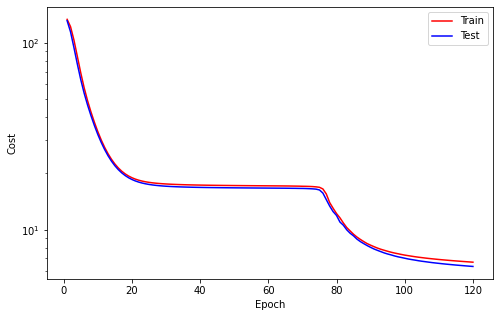

Test: 100%|██████████| 3/3 [00:00<00:00, 33.09it/s]



Epoch   121
Train_cost  = 6.6693 | Test_cost  = 6.3259 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.70it/s]



Epoch   122
Train_cost  = 6.6508 | Test_cost  = 6.3064 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.00it/s]



Epoch   123
Train_cost  = 6.6325 | Test_cost  = 6.2878 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.69it/s]



Epoch   124
Train_cost  = 6.6145 | Test_cost  = 6.2698 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.25it/s]



Epoch   125
Train_cost  = 6.5972 | Test_cost  = 6.2522 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.08it/s]



Epoch   126
Train_cost  = 6.5802 | Test_cost  = 6.2352 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.93it/s]



Epoch   127
Train_cost  = 6.5636 | Test_cost  = 6.2188 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.77it/s]



Epoch   128
Train_cost  = 6.5474 | Test_cost  = 6.2030 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 22.17it/s]



Epoch   129
Train_cost  = 6.5316 | Test_cost  = 6.1877 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.09it/s]



Epoch   130
Train_cost  = 6.5162 | Test_cost  = 6.1728 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.14it/s]



Epoch   131
Train_cost  = 6.5012 | Test_cost  = 6.1584 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.18it/s]



Epoch   132
Train_cost  = 6.4865 | Test_cost  = 6.1445 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.32it/s]



Epoch   133
Train_cost  = 6.4721 | Test_cost  = 6.1311 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.34it/s]



Epoch   134
Train_cost  = 6.4581 | Test_cost  = 6.1182 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.34it/s]



Epoch   135
Train_cost  = 6.4444 | Test_cost  = 6.1057 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.69it/s]



Epoch   136
Train_cost  = 6.4311 | Test_cost  = 6.0937 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.86it/s]



Epoch   137
Train_cost  = 6.4180 | Test_cost  = 6.0822 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.35it/s]



Epoch   138
Train_cost  = 6.4052 | Test_cost  = 6.0710 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.79it/s]



Epoch   139
Train_cost  = 6.3928 | Test_cost  = 6.0602 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.33it/s]



Epoch   140
Train_cost  = 6.3805 | Test_cost  = 6.0497 | 


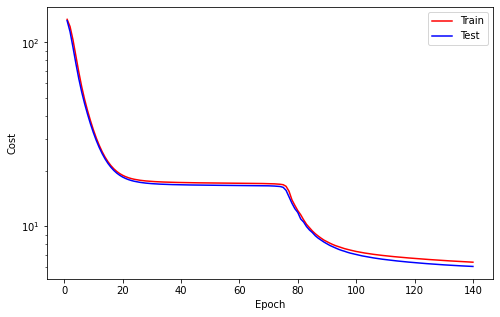

Test: 100%|██████████| 3/3 [00:00<00:00, 31.05it/s]



Epoch   141
Train_cost  = 6.3685 | Test_cost  = 6.0395 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.25it/s]



Epoch   142
Train_cost  = 6.3567 | Test_cost  = 6.0295 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.84it/s]



Epoch   143
Train_cost  = 6.3451 | Test_cost  = 6.0197 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.95it/s]



Epoch   144
Train_cost  = 6.3336 | Test_cost  = 6.0102 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 22.74it/s]



Epoch   145
Train_cost  = 6.3222 | Test_cost  = 6.0008 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.29it/s]



Epoch   146
Train_cost  = 6.3109 | Test_cost  = 5.9917 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.26it/s]



Epoch   147
Train_cost  = 6.2996 | Test_cost  = 5.9829 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.28it/s]



Epoch   148
Train_cost  = 6.2883 | Test_cost  = 5.9745 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.02it/s]



Epoch   149
Train_cost  = 6.2768 | Test_cost  = 5.9670 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.31it/s]



Epoch   150
Train_cost  = 6.2656 | Test_cost  = 5.9611 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.12it/s]



Epoch   151
Train_cost  = 6.2552 | Test_cost  = 5.9576 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.30it/s]



Epoch   152
Train_cost  = 6.2463 | Test_cost  = 5.9554 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.28it/s]



Epoch   153
Train_cost  = 6.2378 | Test_cost  = 5.9511 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.68it/s]



Epoch   154
Train_cost  = 6.2287 | Test_cost  = 5.9429 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.27it/s]



Epoch   155
Train_cost  = 6.2174 | Test_cost  = 5.9321 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 20.87it/s]



Epoch   156
Train_cost  = 6.2054 | Test_cost  = 5.9219 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.55it/s]



Epoch   157
Train_cost  = 6.1920 | Test_cost  = 5.9133 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.22it/s]



Epoch   158
Train_cost  = 6.1820 | Test_cost  = 5.9067 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.61it/s]



Epoch   159
Train_cost  = 6.1725 | Test_cost  = 5.8941 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.26it/s]



Epoch   160
Train_cost  = 6.1727 | Test_cost  = 5.8981 | 


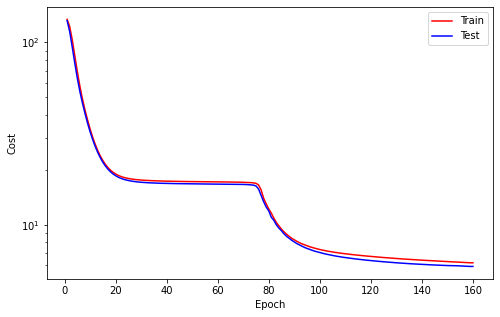

==> EarlyStop patience =  1 | Best test_cost: 5.8941


Test: 100%|██████████| 3/3 [00:00<00:00, 32.51it/s]



Epoch   161
Train_cost  = 6.1612 | Test_cost  = 5.8765 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.79it/s]



Epoch   162
Train_cost  = 6.1500 | Test_cost  = 5.8891 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8765


Test: 100%|██████████| 3/3 [00:00<00:00, 28.22it/s]



Epoch   163
Train_cost  = 6.1379 | Test_cost  = 5.8730 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.30it/s]



Epoch   164
Train_cost  = 6.1295 | Test_cost  = 5.8779 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8730


Test: 100%|██████████| 3/3 [00:00<00:00, 31.49it/s]



Epoch   165
Train_cost  = 6.1199 | Test_cost  = 5.8594 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.92it/s]



Epoch   166
Train_cost  = 6.1158 | Test_cost  = 5.8776 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8594


Test: 100%|██████████| 3/3 [00:00<00:00, 29.85it/s]



Epoch   167
Train_cost  = 6.1076 | Test_cost  = 5.8446 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.38it/s]



Epoch   168
Train_cost  = 6.0935 | Test_cost  = 5.8644 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8446


Test: 100%|██████████| 3/3 [00:00<00:00, 29.12it/s]



Epoch   169
Train_cost  = 6.0859 | Test_cost  = 5.8418 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.87it/s]



Epoch   170
Train_cost  = 6.0730 | Test_cost  = 5.8466 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8418


Test: 100%|██████████| 3/3 [00:00<00:00, 28.25it/s]



Epoch   171
Train_cost  = 6.0670 | Test_cost  = 5.8310 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.91it/s]



Epoch   172
Train_cost  = 6.0582 | Test_cost  = 5.8384 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8310


Test: 100%|██████████| 3/3 [00:00<00:00, 28.58it/s]



Epoch   173
Train_cost  = 6.0517 | Test_cost  = 5.8164 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.25it/s]



Epoch   174
Train_cost  = 6.0435 | Test_cost  = 5.8375 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8164


Test: 100%|██████████| 3/3 [00:00<00:00, 29.39it/s]



Epoch   175
Train_cost  = 6.0395 | Test_cost  = 5.8085 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.84it/s]



Epoch   176
Train_cost  = 6.0267 | Test_cost  = 5.8301 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8085


Test: 100%|██████████| 3/3 [00:00<00:00, 27.18it/s]



Epoch   177
Train_cost  = 6.0224 | Test_cost  = 5.8050 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 26.83it/s]



Epoch   178
Train_cost  = 6.0093 | Test_cost  = 5.8174 | 
==> EarlyStop patience =  1 | Best test_cost: 5.8050


Test: 100%|██████████| 3/3 [00:00<00:00, 28.97it/s]



Epoch   179
Train_cost  = 6.0057 | Test_cost  = 5.8015 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 24.12it/s]



Epoch   180
Train_cost  = 5.9899 | Test_cost  = 5.8125 | 


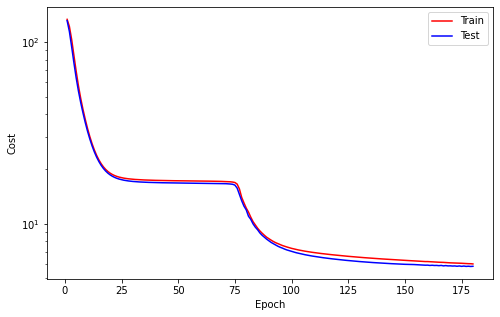

==> EarlyStop patience =  1 | Best test_cost: 5.8015


Test: 100%|██████████| 3/3 [00:00<00:00, 29.92it/s]



Epoch   181
Train_cost  = 5.9937 | Test_cost  = 5.8046 | 
==> EarlyStop patience =  2 | Best test_cost: 5.8015


Test: 100%|██████████| 3/3 [00:00<00:00, 31.10it/s]



Epoch   182
Train_cost  = 5.9784 | Test_cost  = 5.8176 | 
==> EarlyStop patience =  3 | Best test_cost: 5.8015


Test: 100%|██████████| 3/3 [00:00<00:00, 29.51it/s]



Epoch   183
Train_cost  = 5.9837 | Test_cost  = 5.8033 | 
==> EarlyStop patience =  4 | Best test_cost: 5.8015


Test: 100%|██████████| 3/3 [00:00<00:00, 28.23it/s]



Epoch   184
Train_cost  = 5.9736 | Test_cost  = 5.8203 | 
==> EarlyStop patience =  5 | Best test_cost: 5.8015
==> Execute Early Stopping at epoch: 184 | Best test_cost: 5.8015
==> Best model is saved at /content/data/model/lstm


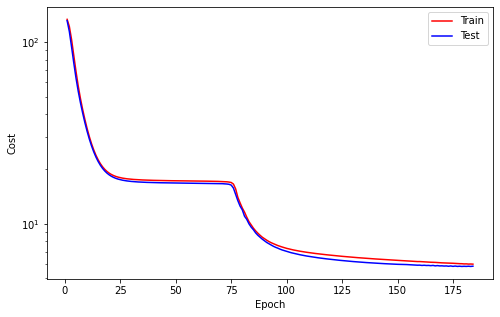

In [19]:
while True:
  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [21]:
# utils
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()   

In [22]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2736, 1, 1)
Note: last 0 data excluded

(N, S, F): (912, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

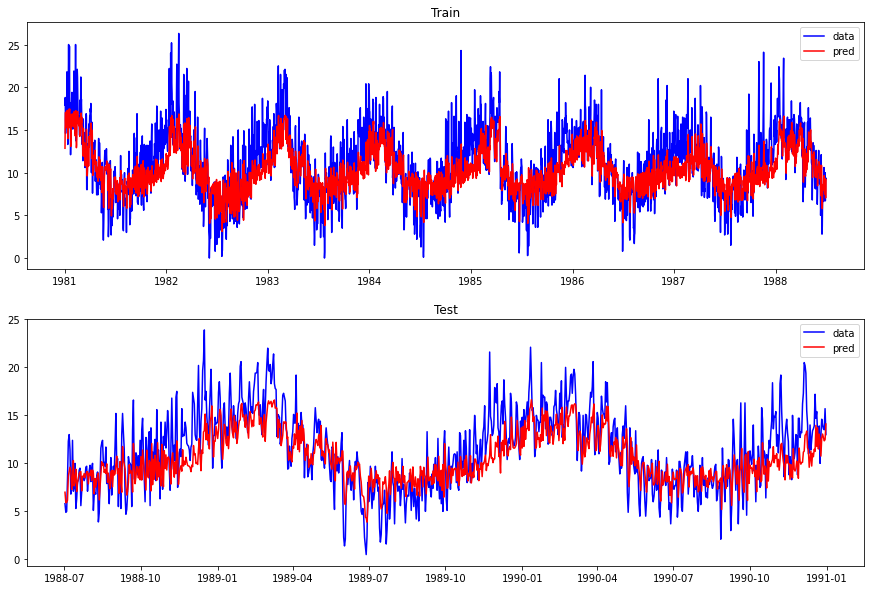

In [23]:
# Data 4 Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

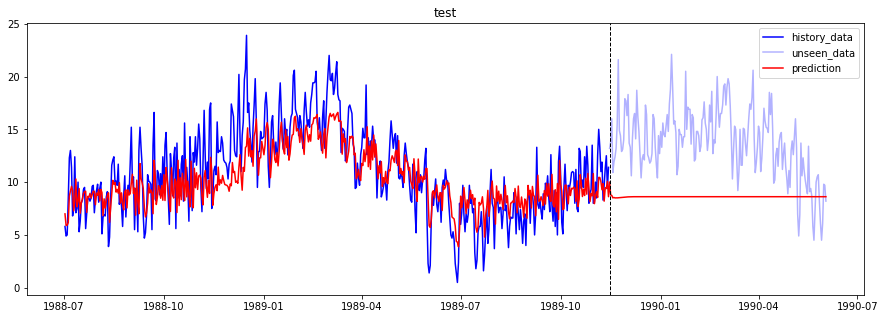

In [24]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")